In [1]:
import torch

In [2]:
import torchvision
import torchvision.datasets as datasets
import torch.tensor as tensor
import torchvision.transforms as transforms
import torch.nn as nn
from torch.autograd import Variable

In [3]:
from matplotlib import pyplot as plt 
from IPython import display

In [4]:
#Generator Class with 4 Layers
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(
            nn.Linear(100,256),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(256,512),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), 100)
        out = self.model(x)
        return out



In [5]:
#Discriminator Network with 4 Layer
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.model(x.view(x.size(0), 784))
        out = out.view(out.size(0), -1)
        return out


In [6]:

discriminator=Discriminator()
generator=Generator()

In [7]:
#Data Preprocessing
data_transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5),std=(0.5))])

In [8]:
#MNIST dataset is downloaded and Loaded with Batchsize=100
train_dataset=datasets.MNIST(root='../../data/',
                                           train=True, 
                                           transform=data_transform,
                                           download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

In [9]:
#Here we use Binary Cross Entropy Loss so as to classify fake and Real Images 
criterion=nn.BCELoss()
lr=0.0001
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

In [10]:
#First Discriminator is trained with Input and Classify as Real and Fake image
def train_discriminator(discriminator,realimg,real_label,fakeimg,fake_label):
    discriminator.zero_grad()
    outputs = discriminator(realimg)
    real_loss = criterion(outputs, real_labels)
    real_score = outputs
    
    outputs = discriminator(fakeimg) 
    fake_loss = criterion(outputs, fake_labels)
    fake_score = outputs
    d_loss=real_loss+fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss,real_score,fake_score


In [11]:
#Then Train Generator so as to generate more realistic so as to fool discriminator
def train_generator(generator,discriminator_output,real_label):
    generator.zero_grad()
    g_loss=criterion(discriminator_output,real_label)
    g_loss.backward()
    g_optimizer.step()
    return g_loss

In [12]:
test_samples=9
test_noise=Variable(torch.randn(test_samples,100))

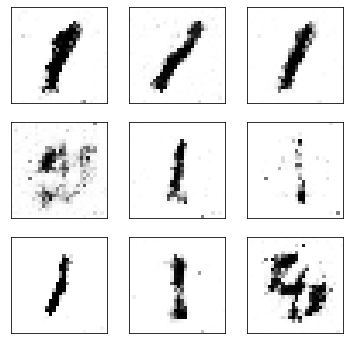

Epoch [10/10], Step[600/600], d_loss: 0.4093, g_loss: 3.1049, D(x): 0.86, D(G(z)): 0.11


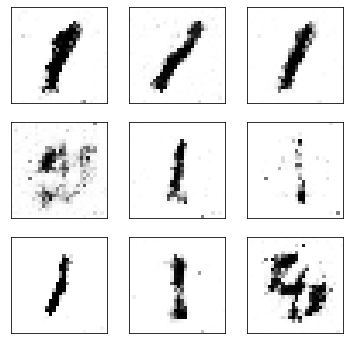

In [15]:
import math
size_figure_grid = int(math.sqrt(test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i in range(size_figure_grid):
    for j in range(size_figure_grid):
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)


num_epochs=10
num_batches=len(train_loader)
num_fig=0
print(num_batches)
for epoch in range(num_epochs):
    for n,(images,_) in enumerate(train_loader):
        images=Variable(images)
        real_labels=Variable(torch.ones(images.size(0)))
        noise = Variable(torch.randn(images.size(0), 100))
        fake_images = generator(noise)
        fake_labels = Variable(torch.zeros(images.size(0)))
        
        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(discriminator, images, real_labels, fake_images, fake_labels)
        
        # Sample again from the generator and get output from discriminator
        noise = Variable(torch.randn(images.size(0), 100))
        fake_images = generator(noise)
        outputs = discriminator(fake_images)

        # Train the generator
        g_loss = train_generator(generator, outputs, real_labels)

        if (n+1)%100 ==0:
            test_out=generator(test_noise)

            for k in range(test_samples):
                i = k//3
                j = k%3
                ax[i,j].cla()
                ax[i,j].imshow(test_out[k,:].data.numpy().reshape(28, 28), cmap='Greys')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            num_fig+=1
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
                  'D(x): %.2f, D(G(z)): %.2f' 
                  %(epoch + 1, num_epochs, n+1, num_batches, d_loss.item(), g_loss.item(),
                    real_score.data.mean(), fake_score.data.mean()))




In [ ]:
# The Model Can be further improved by tuning the Hyperparameters